# Concrete Strength dataset 

This work is an analysis of the application of linear regression methods on concrete data. The goal is to predict the compressive strength of the concrete for some givern characteristics

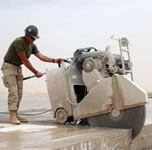

This dataset was provided by **I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)** and it's available at https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

%matplotlib inline

def custom_describe(dataset):
    df = dataset.describe().T
    df = df.drop(columns=['count'])
    df['skewness'] = dataset.skew(axis=0).values
    df['maxmin_ratio'] = df['max']/df['min']
    return df

## Loading data and applying preprocessing steps

In [10]:
dataset = pd.read_csv('Concrete_Data_Yeh.csv')

df = custom_describe(dataset.drop(columns=['csMPa']))
df = df[df.maxmin_ratio > 20]
columns = df.index.values
df = dataset

for item in columns:
    df[item] = power_transform(df[item].values.reshape(-1,1), method='yeo-johnson').reshape(1,-1)[0]
    
df = df.drop(columns=['csMPa'])

scaler = StandardScaler()
scaler.fit(df)
data = scaler.transform(df)

for i, col in enumerate(df.columns):
    df[col] = data[:,i]

In [14]:
X = df
y = dataset['csMPa']

## Ordinary Linear Regression

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training...")
reg = LinearRegression().fit(X_train, y_train)
print("Training done.\n")

print("Intercept: " + str(round(reg.intercept_, 2)))
print("Coefficients: " + str([round(i, 2) for i in reg.coef_]))

print("\n# TRAIN PERFORMANCE #")
train_rmse = mean_squared_error(y_train, reg.predict(X_train))
train_r2 = r2_score(y_train, reg.predict(X_train))
print("RMSE: " + str(train_rmse))
print("R2: " + str(train_r2))

print("\n# TEST PERFORMANCE #")
test_rmse = mean_squared_error(y_test, reg.predict(X_test))
test_r2 = r2_score(y_test, reg.predict(X_test))
print("RMSE: " + str(test_rmse))
print("R2: " + str(test_r2))

Training...
Training done.

Intercept: 35.71
Coefficients: [9.29, 5.69, 0.68, -3.93, 2.78, 0.53, -0.4, 10.03]

# TRAIN PERFORMANCE #
RMSE: 55.49015859137497
R2: 0.8028348313935073

# TEST PERFORMANCE #
RMSE: 52.61792735885939
R2: 0.8057457220215303


In [83]:
k = 10
print(f"\n# {k}-FOLD CV PERFORMANCE #")

kf = KFold(n_splits=k)

kf_rmse = []
kf_r2 = []
i = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    reg = LinearRegression().fit(X_train, y_train)
    
    test_rmse = mean_squared_error(y_test, reg.predict(X_test))
    test_r2 = r2_score(y_test, reg.predict(X_test))
    
    print(f"\n  FOLD-{i}")
    print(f"   Test RMSE: {test_rmse}")
    print(f"   Test R2: {test_r2}")
    
    kf_rmse.append(test_rmse)
    kf_r2.append(test_r2)
    i+=1
    
print(f'''
Summary:
  {k}-fold Average RMSE: {np.mean(kf_rmse)}
  {k}-fold Average R2: {np.mean(kf_r2)}
''')


# 10-FOLD CV PERFORMANCE #

  FOLD-1
   Test RMSE: 91.62551048622356
   Test R2: 0.34060445189784117

  FOLD-2
   Test RMSE: 104.66186608245091
   Test R2: 0.7156630493581033

  FOLD-3
   Test RMSE: 48.312556343551755
   Test R2: 0.6736793047903467

  FOLD-4
   Test RMSE: 99.95001293779744
   Test R2: 0.6121717481828297

  FOLD-5
   Test RMSE: 72.88702133883008
   Test R2: 0.6288810522153532

  FOLD-6
   Test RMSE: 44.2504338211221
   Test R2: 0.7292391190558145

  FOLD-7
   Test RMSE: 22.541338946318323
   Test R2: 0.8693834302081663

  FOLD-8
   Test RMSE: 34.27223487752531
   Test R2: 0.8545184452357154

  FOLD-9
   Test RMSE: 65.72558211552479
   Test R2: 0.590612856930435

  FOLD-10
   Test RMSE: 64.58863115932711
   Test R2: 0.5519811142593551

Summary:
  10-fold Average RMSE: 64.88151881086714
  10-fold Average R2: 0.6566734572133961



## Ridge regression (L2)

In [81]:
k = 10
kf = KFold(n_splits=k)


for alpha in np.linspace(0, 15, 10):
    print(f"Training with alpha = {alpha}...")
    
    kf_rmse = []
    kf_r2 = []
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        reg = Ridge(alpha=alpha, random_state=4).fit(X_train, y_train)

        test_rmse = mean_squared_error(y_test, reg.predict(X_test))
        test_r2 = r2_score(y_test, reg.predict(X_test))

        print(f"\n    FOLD-{i}")
        print(f"     RMSE: {test_rmse}")
        print(f"     R2: {test_r2}")

        kf_rmse.append(test_rmse)
        kf_r2.append(test_r2)
        i+=1

    print(f'''
  Summary:
    {k}-fold Average RMSE: {np.mean(kf_rmse)}
    {k}-fold Average R2: {np.mean(kf_r2)}
    Coefficients: {[round(i, 2) for i in reg.coef_]}
    Intercept: {round(reg.intercept_, 2)}
    ''')
    print("##############################################")



Training with alpha = 0.0...

    FOLD-1
     RMSE: 91.62551048622365
     R2: 0.3406044518978406

    FOLD-2
     RMSE: 104.66186608245111
     R2: 0.7156630493581028

    FOLD-3
     RMSE: 48.3125563435516
     R2: 0.6736793047903477

    FOLD-4
     RMSE: 99.95001293779728
     R2: 0.6121717481828304

    FOLD-5
     RMSE: 72.88702133883028
     R2: 0.6288810522153521

    FOLD-6
     RMSE: 44.25043382112198
     R2: 0.7292391190558154

    FOLD-7
     RMSE: 22.541338946318312
     R2: 0.8693834302081664

    FOLD-8
     RMSE: 34.27223487752523
     R2: 0.8545184452357157

    FOLD-9
     RMSE: 65.72558211552482
     R2: 0.5906128569304347

    FOLD-10
     RMSE: 64.58863115932702
     R2: 0.5519811142593557

  Summary:
    10-fold Average RMSE: 64.88151881086714
    10-fold Average R2: 0.6566734572133962
    Coefficients: [8.38, 4.83, 0.83, -4.98, 2.65, -0.22, -1.61, 10.03]
    Intercept: 36.12
    
##############################################
Training with alpha = 1.666666666666

## Partial Least Squares

In [87]:
[i for i in range(1, X.shape[1]+1)]

[1, 2, 3, 4, 5, 6, 7, 8]

In [91]:
k = 10
kf = KFold(n_splits=k)


for n_components in range(1, X.shape[1]+1):
    print(f"Training with {n_components} components...")
    
    kf_rmse = []
    kf_r2 = []
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        reg = PLSRegression(n_components=n_components).fit(X_train, y_train)

        test_rmse = mean_squared_error(y_test, reg.predict(X_test))
        test_r2 = r2_score(y_test, reg.predict(X_test))

        print(f"\n    FOLD-{i}")
        print(f"     RMSE: {test_rmse}")
        print(f"     R2: {test_r2}")

        kf_rmse.append(test_rmse)
        kf_r2.append(test_r2)
        i+=1

    print(f'''
  Summary:
    {k}-fold Average RMSE: {np.mean(kf_rmse)}
    {k}-fold Average R2: {np.mean(kf_r2)}
    ''')
    print("##############################################")



Training with 1 components...

    FOLD-1
     RMSE: 137.41323558054015
     R2: 0.011086810744208142

    FOLD-2
     RMSE: 170.8169886637333
     R2: 0.5359381263447469

    FOLD-3
     RMSE: 39.61532235115702
     R2: 0.7324236076713113

    FOLD-4
     RMSE: 139.12444900951576
     R2: 0.4601662345159817

    FOLD-5
     RMSE: 80.57408131266833
     R2: 0.5897408382699041

    FOLD-6
     RMSE: 34.78292904197803
     R2: 0.7871691711024621

    FOLD-7
     RMSE: 30.152794373141774
     R2: 0.8252785879295982

    FOLD-8
     RMSE: 32.63512765266534
     R2: 0.8614677704034376

    FOLD-9
     RMSE: 99.6336411528662
     R2: 0.37940858958850376

    FOLD-10
     RMSE: 102.80466382721754
     R2: 0.2868956949529595

  Summary:
    10-fold Average RMSE: 86.75532329654834
    10-fold Average R2: 0.5469575431523114
    
##############################################
Training with 2 components...

    FOLD-1
     RMSE: 103.83689414042574
     R2: 0.25272355524560286

    FOLD-2
     RMSE